In [37]:
import pandas as pd
import re
import numpy as np
import itertools
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)

In [5]:
df = pd.read_sas(r'C:\Users\user\Downloads\CBC_E.XPT', format='xport', encoding='utf-8')

In [8]:
df.to_excel(r'C:\Users\user\Downloads\cbc.xlsx')

In [40]:
df.fillna(0, inplace=True)

In [18]:
df10 = pd.read_excel(r'C:\Users\user\Documents\df10.xlsx')
df10['Analyte Description'] = df10['Analyte Description'].apply(lambda x: x.replace(' ', '_'))
df10['Analyte Description'] = df10['Analyte Description'].apply(lambda x: x.lower())
analyte_cols = df10.set_index(['Variable Name'])['Analyte Description'].to_dict()
analyte_cols['LBDNENO'] = 'segmented_neutrophils_num'
analyte_cols['LBDLYMNO'] = 'lymphocyte_num'
analyte_cols['LBDEONO'] = 'eosinophils_num'
analyte_cols['LBDBANO'] = 'basophils_num'
analyte_cols['LBDMONO'] = 'monocyte_number'
analyte_cols['LBXHCT'] = 'hematocrit_percent'
analyte_cols['LBXMCHSI'] = 'mean_cell_hemoglobin'
analyte_cols['LBXMC'] = 'mean_cell_hgb_concentration'
df = df.rename(analyte_cols, axis=1)

In [34]:
df.dtypes

SEQN                             float64
white_blood_cell_count           float64
lymphocyte_percent               float64
monocyte_percent                 float64
segmented_neutrophils_percent    float64
eosinophils_percent              float64
basophils_percent                float64
lymphocyte_num                   float64
monocyte_number                  float64
segmented_neutrophils_num        float64
eosinophils_num                  float64
basophils_num                    float64
red_blood_cell_count             float64
hemoglobin                       float64
hematocrit_percent               float64
mean_cell_volume                 float64
mean_cell_hemoglobin             float64
mean_cell_hgb_concentration      float64
red_cell_distribution_width      float64
platelet_count                   float64
mean_platelet_volume             float64
dtype: object

red_blood_cell_count excluded!
hematocrit_percent excluded!
hemoglobin excluded!
MSE: 0.1998


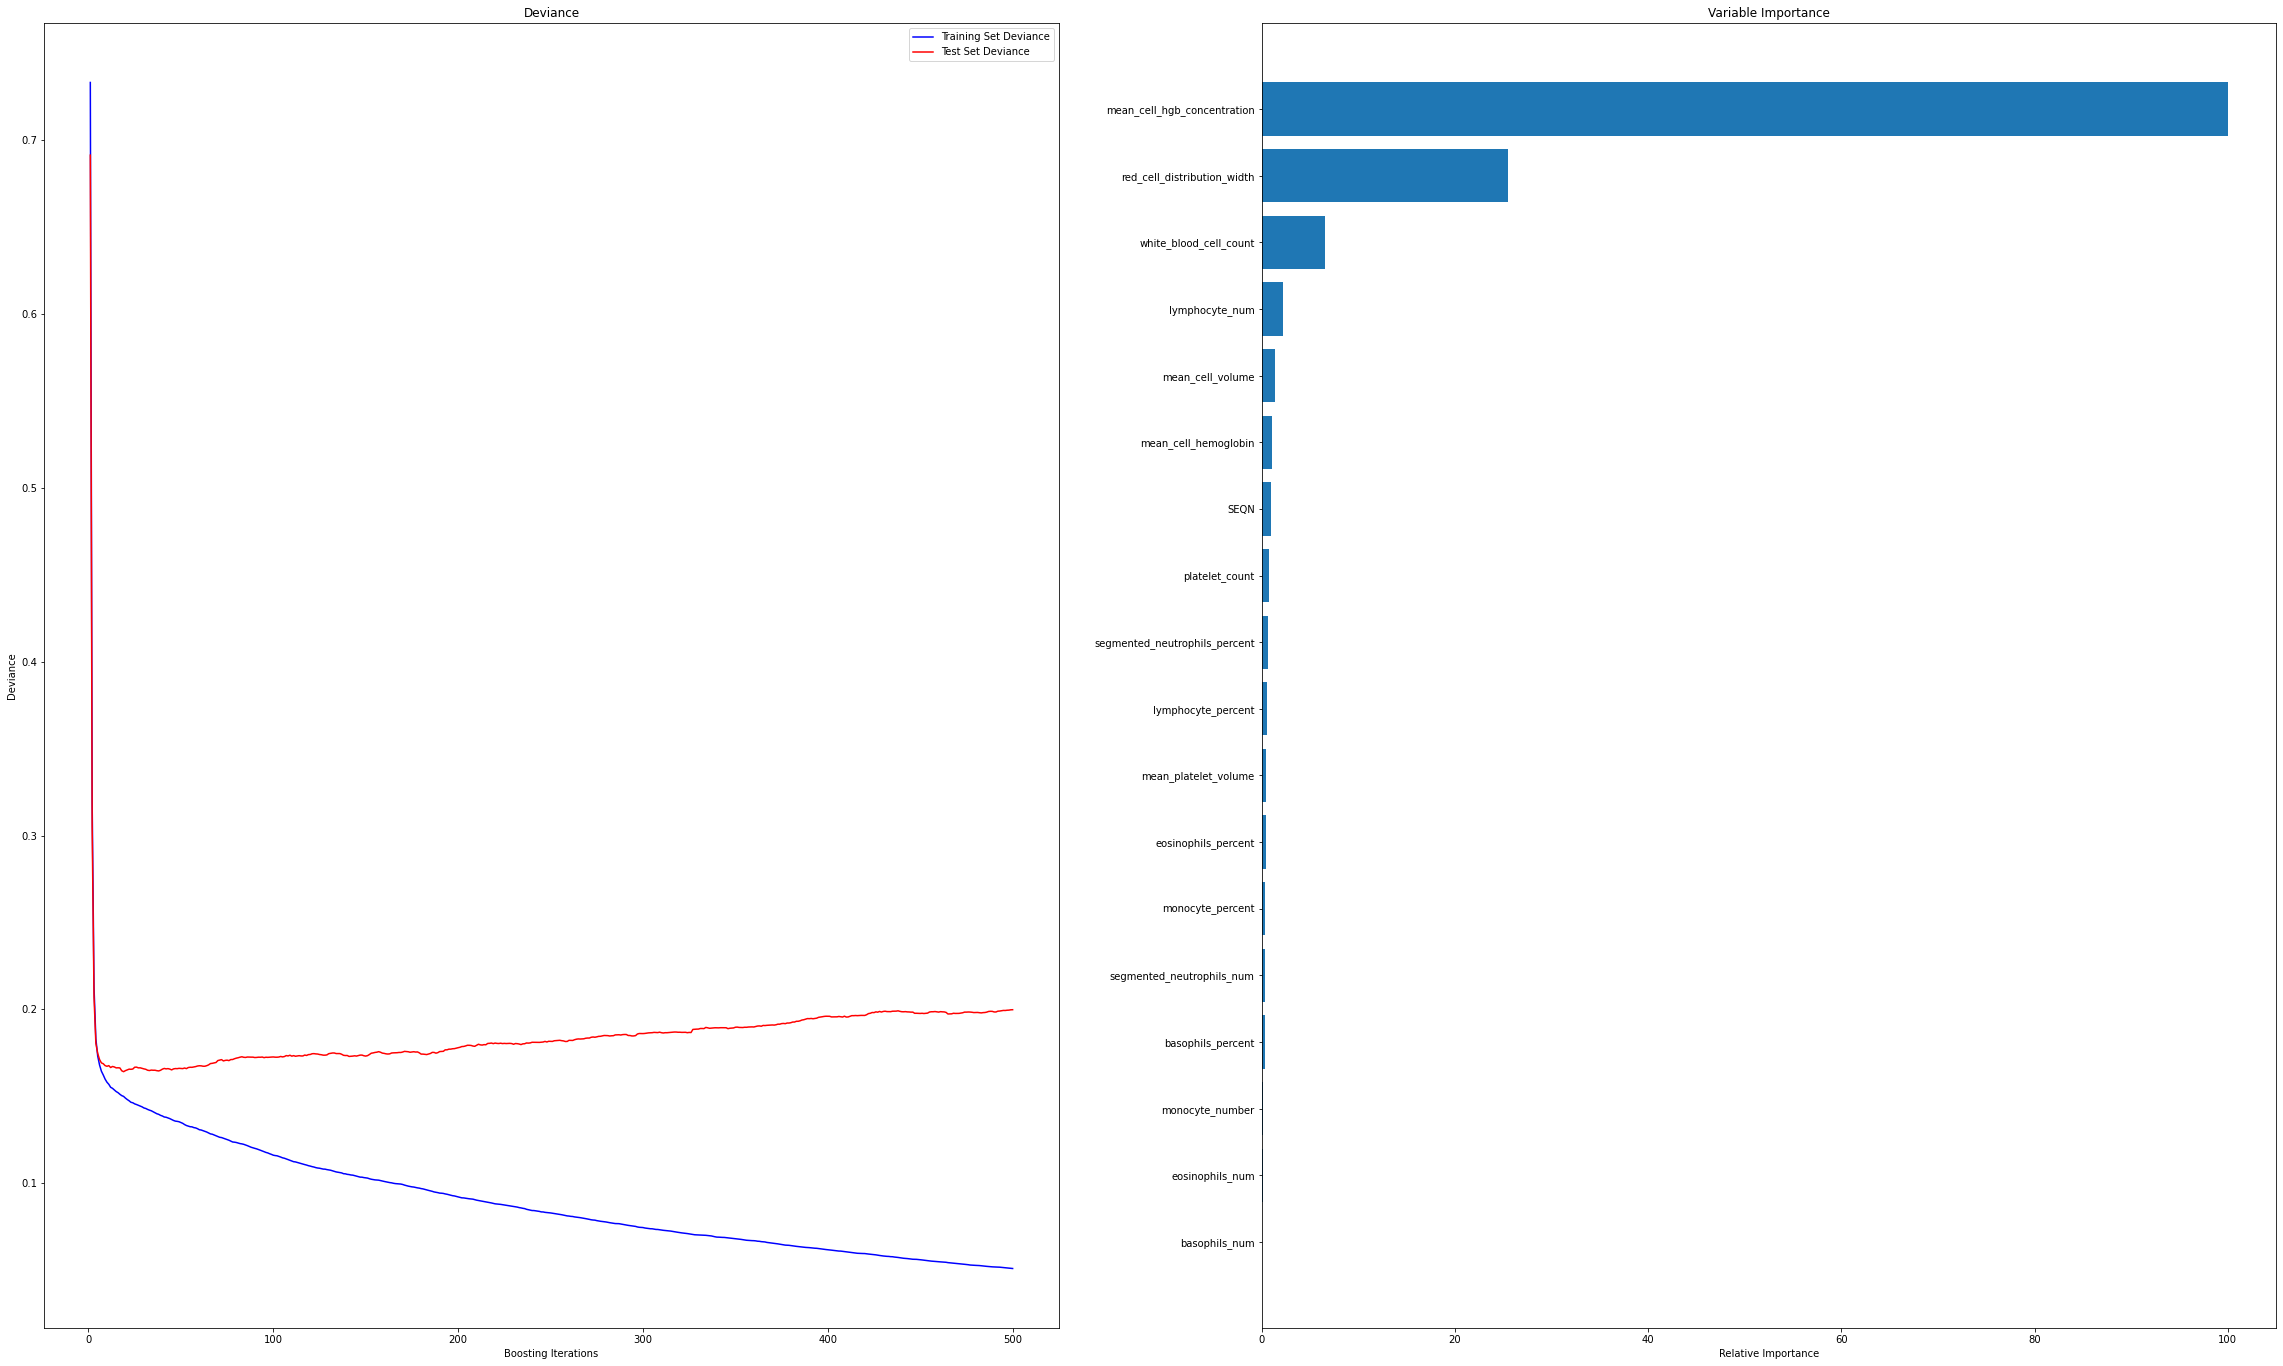

In [56]:
# Shuffle Data

dependent_var = 'red_blood_cell_count'
excluded = [dependent_var, 'hematocrit_percent', 'hemoglobin']
independent_vars = [i for i in df.columns]
for each in excluded:
    if each in independent_vars:
        print('{} excluded!'.format(each))
        independent_vars.remove(each)

ylabels = df[dependent_var].unique()

input_y = df.loc[:, dependent_var]
input_x = df.loc[:, independent_vars]

X, y = shuffle(input_x, input_y, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# Fit regression model
params = {'n_estimators': 500, 'learning_rate': 0.5}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(40, 24))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, input_x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()